In [1]:
import numpy as np
from numpy import pi
from snorer import Constants,radiusInfluence,radiusSchwarzschild,rhox
import matplotlib.pyplot as plt
from fractions import Fraction

In [7]:
import snorer as sn

In [17]:
class HaloSpike(Constants):
    """
    Class for constructing dark matter halo with spike due to supermassive black hole
    (SMBH) in the galactic center.

    /*-----------------------------------------------------------------------------*/

    
    ********************
    *                  *
    *   Class Inputs   *
    *                  *
    ********************
    
      mBH: SMBH mass, Msun
      tBH: SMBH age, years
    alpha: Slope of the spike profile


    ********************
    *                  *
    *    Attributes    *
    *                  *
    ********************

    When a HaloSpike instance is initialized, the following attributes will be assigned,

      mBH: SMBH mass, Msun
      tBH: SMBH age, years
    alpha: Slope of the spike profile
       rh: SMBH influence radius, kpc
       Rs: Schwarzschild radius, kpc
    
    where the first four are the inputs with the last one auto-generated when initializing
    the instance. 
    
    >>> nx = HaloSpike(mBH=1e7,tBH=1e10,alpha='3/2')   # initializing HaloSpike instance
    
    Basic properties of the instance can be viewd by

    >>> nx
               SMBH mass: 1.000e+07 M_sun
             Spike slope: 3/2
    Schwarzschild radius: 9.504e-10 kpc
        Influence radius: 3.412e-03 kpc

    In principle, alpha is a str type and can be converted into float number by

    >>> eval(nx.alpha)
    1.5

    One can also reset alpha by

    >>> nx.alpha = '7/3'   # reset alpha
    >>> nx.alpha
    '7/3
    
    The SMBH influence radius rh, kpc, is auto-generated by the stellar dispersion relation
    via M-sigma relation given the input SMBH mass. It can be viewed by

    >>> nx.rh   # kpc
    0.003411783398329804

    If you do not satisfy the generated rh, you can change it to your preferred value
     
    >>> nx.rh = 2.54e-3
    >>> nx.rh
    2.54e-03
    
    But this new value may not agree with the astrophysical consensus and you better have good
    reason to do so! However, if you want to restore the default rh generated by the stellar
    dispersion relation, you can simply do

    >>> nx.rh = None     # restore the default rh
    >>> nx.rh            # the default value
    0.003411783398329804
    
    Additionally, Schwarzschild radius and influence radius are subject to mBH and alpha. Once
    any of the mBH and alpha is modfied, the corresponding radius will change accordingly.
    However, if you customize your own rh, when you modfiy mBH or alpha, rh will restore to its
    default value associated with mBH and alpha instead of user-defined value. You have to reset
    rh to your preferable value again.
    
    **********************
    *                    *
    *      Callable      *
    *                    *
    **********************

    After initializing the HaloSpike instance, it is callable like normal function with the
    following required inputs. The output is the DM number density, #/cm^3, at r

        r: Distance to GC, kpc
       mx: DM mass, MeV
     sigv: DM annihilation cross section in the unit of cm^3/s
           None means no annihilation
     rhos: Charasteristic density, MeV/cm^3
       rs: Characteristic radius, kpc
        n: Slope of the DM profile outside R_spike

    The parameters (r,rhos,rs,n) are the same in the function snorer.rhox and they are the
    general parameterization for NFW profile. See our paper for more explanation.

    Now we can get the DM number density by

    >>> nx(r=1e-7,mx=1e-3,sigv=None,rhos=184,rs=24,n=2)
    7185012798674088.0

    See Phys. Rev. Lett. 83, 1719 (1999), arXiv:astro-ph/9906391 for the theoretical foundation
        JCAP 06, 004 (2023), arXiv:2301.08756 for the parameterizations deployed here
    """

    def __init__(self,mBH,tBH,alpha):
        self._mBH = mBH
        self.tBH = tBH
        self._alpha = self._check_alpha(alpha)

        # Quantities to be evaluated
        self._rh = None
        self._Rs = None
        self._norm = None

    def __repr__(self):
        return '{:>21s}'.format('SMBH mass:') + ' {:>.3e} M_sun'.format(self.mBH) + '\n' +                 \
               '{:>21s}'.format('Spike slope:') + ' {}'.format(self.alpha) + '\n' + \
               '{:>21s}'.format('Schwarzschild radius:') + ' {:>.3e} kpc'.format(self.Rs) + '\n' +              \
               '{:>21s}'.format('Influence radius:') + ' {:>.3e} kpc'.format(self.rh)

    # mBH property and setter
    @property
    def mBH(self):
        return self._mBH

    @mBH.setter
    def mBH(self,new_mBH):
        self._mBH = new_mBH
        self._Rs = None # Set it to None will make Rs re-evaluated with new mBH
        self._norm = None # Set it to None will make norm re-evaluated with new mBH
        self._rh = None  # Set it to None will make h re-evaluated with new mBH
    
    # Schwarzschild radius
    @property
    def Rs(self):
        if self._Rs is None:
            # mBH is updated, evlaute the corresponding new Rs
            self._Rs = radiusSchwarzschild(self.mBH)
        return self._Rs

    # Influence radius property
    @property
    def rh(self):
        if self._rh is None:
            # mBH is updated, evlaute the corresponding new rh
            self._rh = radiusInfluence(self.mBH)
        return self._rh

    @rh.setter
    def rh(self,new_rh):
        self._rh = new_rh
        self._norm = None # Set it to None will make norm re-evaluated with new rh
    
    # Spike index
    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self,new_alpha):
        self._alpha = self._check_alpha(new_alpha)
        self._norm = None # Set it to None will make norm re-evaluated with new alpha

    # Normalization factor
    @property
    def norm(self):
        if self._norm is None:
            self._norm = self._normN()
        return self._norm

    def _check_alpha(self,alpha) -> str:
        if alpha in ('3/2','7/3'):
            return alpha
        else:
            raise FlagError('Spike index \'alpha\' must be either [\'3/2\' or \'7/3\'].')

    def _normN(self) -> float:
        """
        The normalization N
        
        Output
        ------
        normalization N
        """
        # ini parameters
        mBH = self.mBH
        rh = self.rh
        Rs = self.Rs
        ri = 4*Rs
        alpha = eval(self.alpha)
        
        def _fa(r,alpha):
            return (r**3 / (3 - alpha) + 12 * Rs * r**2 / (alpha - 2) - 48 * Rs**2 * r / (alpha - 1) + 64 * Rs**3 / alpha) / r**alpha

        fh,fi = _fa(rh,alpha),_fa(ri,alpha)
        norm = mBH * self.Msun / 4 / pi / (fh - fi)
        return norm

    def _radiusSpike(self,rhos,rs) -> float:
        """
        Get the spike radius

        Input
        ------
        rhos: characteristic density, MeV/cm^3
        rs: characteristic radius, kpc

        Output
        ------
        R_spike: Spike radius, kpc
        """
        # Parameter
        rh = self.rh
        alpha = eval(self.alpha)
        norm = self.norm
        rhos = rhos * self.kpc2cm**3
        if self.alpha == '3/2':
            return (norm / rhos / rs)**(3/4) * rh**(5/8)
        elif self.alpha == '7/3':
            return (norm / rhos / rs)**(3/4)

    def _rhoPrime(self,r,Rsp,norm) -> float:
        """
        Get rho'

        Input
        ------
        r: distance to GC, kpc
        Rsp: Spike radius, kpc
        norm: Normalization factor

        Output
        ------
        rhoPrime: MeV/cm^3
        """
        # Parameters
        Rs = self.Rs
        rh = self.rh
        alpha = eval(self.alpha)
        ri = 4 * Rs

        if self.alpha == '3/2':
            rhoN = norm / rh**alpha
            rhoNp = rhoN * (rh / Rsp)**(7/3)
            if ri <= r < rh:
                rhoP = rhoN * (1 - ri / r)**3 * (rh / r)**alpha
            else:
                rhoP = rhoNp * (Rsp / r)**(7 / 3)
            return rhoP / self.kpc2cm**3
        elif self.alpha == '7/3':
            rhoN = norm / Rsp**(7/3)
            rhoP = rhoN * (1 - 4 * Rs / r)**3 * (Rsp / r)**alpha
            return rhoP / self.kpc2cm**3

    def _nxSpike(self,r,mx,sigv,rhos,rs,n) -> float:
        """
        DM number density with spike in the center

        Input
        ------
        r: distance to GC, kpc
        mx: DM mass, MeV
        sigv: DM annihilation cross section, in the unit of 1e-26 cm^3/s
            None indicates no annihilation
        rhos: The characteristic density, MeV/cm^3
        rs: The characteristic radius, kpc
        n: Slope of the DM profile

        Output
        ------
        number density: #/cm^3
        """
        # Parameters
        Rs = self.Rs
        Rsp = self._radiusSpike(rhos,rs)
        norm = self.norm
        tBH = self.tBH
        ri = 4*Rs
        
        if sigv is None:  # no DM annihilation
            if r < ri:
                return 0
            elif ri <= r < Rsp:
                return self._rhoPrime(r,Rsp,norm) / mx
            else:
                return rhox(r,rhos,rs,n)/mx
        else: # non-zero DM annihilation
            sigv = sigv * 1e-26
            rhoc = mx / sigv / tBH / self.year2Seconds
            if r < ri:
                return 0
            elif ri <= r < Rsp:
                rhoP = self._rhoPrime(r,Rsp,norm)
                return rhoP * rhoc / (rhoP + rhoc) / mx
            else:
                rhoDM = rhox(r,rhos,rs,n)
                return rhoDM * rhoc / (rhoDM + rhoc) / mx
                
    def __call__(self,r,mx,sigv,rhos,rs,n) -> float:
        """
        Obtain the DM number density in the presence of spike
        
        Input
        ------
        r: distance to GC, kpc
        mx: DM mass, MeV
        sigv: DM annihilation cross section, in the unit of 1e-26 cm^3/s
            None indicates no annihilation
        rhos: The characteristic density, MeV/cm^3
        rs: The characteristic radius, kpc
        n: Slope of the DM profile

        Output
        ------
        number density: #/cm^3
        """
        return self._nxSpike(r,mx,sigv,rhos,rs,n)

In [29]:
myhalo=HaloSpike(mBH=1e7,tBH=1e10,alpha='3/2')

In [31]:
myhalo

           SMBH mass: 1.000e+07 M_sun
         Spike slope: 3/2
Schwarzschild radius: 9.504e-10 kpc
    Influence radius: 3.412e-03 kpc

In [69]:
myhalo.mBH = 1e6

In [71]:
myhalo.rh,myhalo.norm,myhalo.Rs

(0.0008416631523073906, 5.450678344356737e+69, 9.503662884927067e-11)

In [73]:
myhalo.alpha= '7/3'

In [75]:
myhalo.rh,myhalo.norm,myhalo.Rs

(0.0008416631523073906, 6.63786321952644e+66, 9.503662884927067e-11)

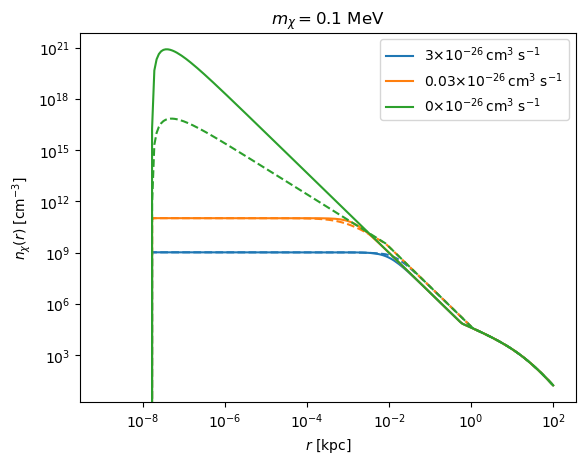

In [37]:
# Get MW rhos, rs, n, mBH and rh
rhos,rs,n,mBH,rh = Constants().MW_profile.values()
# Assuming BH age is 1 Gyr
tBH = 1e9
# DM mass, MeV
mx = 0.1
# Annihilation cross section
sigv_list = [3,0.03,None]
sigv_label = ['3','0.03','0']
# Initializing instances with two different alphas
nx = HaloSpike(mBH=10*mBH,tBH=tBH,alpha='7/3')  # alpha = 3/2
nx_low = HaloSpike(mBH=10*mBH,tBH=tBH,alpha='3/2')  # alpha = 3/2
# radius, kpc
r_vals = np.logspace(-9,2,200)

colors=['C0','C1','C2']

for i in range(3):
    sigv = sigv_list[i]
    nx_vals = [nx(r,mx,sigv,rhos,rs,n) for r in r_vals]
    nxlow_vals = [nx_low(r,mx,sigv,rhos,rs,n) for r in r_vals]
    plt.plot(r_vals,nx_vals,label=sigv_label[i] + r'$\times10^{-26}\,{\rm cm^3~s^{-1}}$',color=colors[i])
    plt.plot(r_vals,nxlow_vals,'--',color=colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi(r)$ [cm$^{-3}$]')
plt.title(fr'$m_\chi = {mx:.1f}$ MeV')
plt.legend()
plt.show()

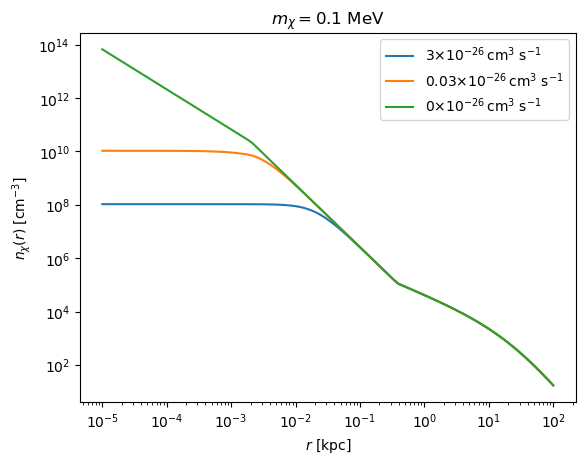

In [21]:
# Get MW rhos, rs, n, mBH and rh
rhos,rs,n,mBH,rh = Constants().MW_profile.values()
# Assuming BH age is 1 Gyr
tBH = 1e10
# DM mass, MeV
mx = 0.1
# Annihilation cross section
sigv_list = [3,0.03,None]
sigv_label = ['3','0.03','0']
# Initializing instances with two different alphas
nx = HaloSpike(mBH=mBH,tBH=tBH,alpha='3/2')  # alpha = 3/2

# radius, kpc
r_vals = np.logspace(-5,2,100)

for i in range(3):
    sigv = sigv_list[i]
    nx_vals = [nx(r,mx,sigv,rhos,rs,n) for r in r_vals]
    plt.plot(r_vals,nx_vals,label=sigv_label[i] + r'$\times10^{-26}\,{\rm cm^3~s^{-1}}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi(r)$ [cm$^{-3}$]')
plt.title(fr'$m_\chi = {mx:.1f}$ MeV')
plt.legend()
plt.show()

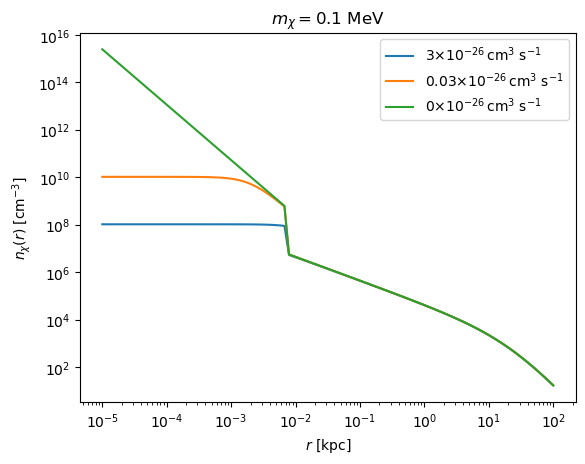

In [11]:
# Get MW rhos, rs, n, mBH and rh
rhos,rs,n,mBH,rh = Constants().MW_profile.values()
# Assuming BH age is 1 Gyr
tBH = 1e10
# DM mass, MeV
mx = 0.1
# Annihilation cross section
sigv_list = [3,0.03,None]
sigv_label = ['3','0.03','0']
# Initializing instances with two different alphas
nx = sn.HaloSpike(mBH=mBH,tBH=tBH,alpha='7/3')  # alpha = 3/2

# radius, kpc
r_vals = np.logspace(-5,2,100)

for i in range(3):
    sigv = sigv_list[i]
    nx_vals = [nx(r,mx,sigv,rhos,rs,n) for r in r_vals]
    plt.plot(r_vals,nx_vals,label=sigv_label[i] + r'$\times10^{-26}\,{\rm cm^3~s^{-1}}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi(r)$ [cm$^{-3}$]')
plt.title(fr'$m_\chi = {mx:.1f}$ MeV')
plt.legend()
plt.show()